In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

For ease of understanding, consider 2 x 2 black and white images. Correct image will have darker shades in diagonal and would look like a backslash.

In [1]:
### Import Libraries

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# some global variables

RANDOM_STATE = 24

np.random.RandomState(seed=RANDOM_STATE);

# input and output directories
inpDir = '../input'
outDir = '../output'

# Set the ploting parameters
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 4),
          'axes.labelsize': 'medium',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium',
          #'text.usetex':True,
          #'text.latex.unicode':True
         }

plt.rcParams.update(params)

# Hyperparameters
ALPHA = 0.01 # learning rate

EPOCHS = 1000

## Helper Functions

In [3]:
# Plot Images
'''
    Our colors are reversed. Need to correct before displaying in Matplotlib
'''

def fn_plot_samples(samples, m, n):

    fig, axes = plt.subplots(figsize=(n*2, m*2), # as per the elements
                             nrows=m, ncols=n,  # columns and rows
                             sharey=True, sharex=True) # same axis for all images

    axes = axes.flatten()

    for ax, img in zip(axes, samples):

        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

        im = ax.imshow( 1 - img.reshape((2,2)), cmap='Greys_r')  # show images

    return fig, axes

## Sigmoid Activation Function

In [4]:
# The sigmoid activation function
def fn_sigmoid(z):
    '''
    Args:
        z: scalar or vector
    Return:
        Sigmoid value; scalar or vector
    '''
    return 1/(1.0 + np.exp(-z))

## Sample Faces

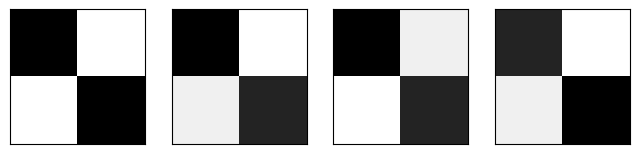

In [5]:
# Examples of faces

faces = [np.array ( [ 1.0, 0.0, 0.0, 1.0 ] ),
         np.array ( [ 0.9, 0.1, 0.2, 0.8 ] ),
         np.array ( [ 0.9, 0.2, 0.1, 0.8 ] ),
         np.array ( [ 0.8, 0.1, 0.2, 0.9 ] ),
         np.array ( [ 0.8, 0.2, 0.1, 0.9 ] )]

_ = fn_plot_samples(faces, 1, 4)

# Sample noise

The following are randomly generated images, which don't correspond to any face.


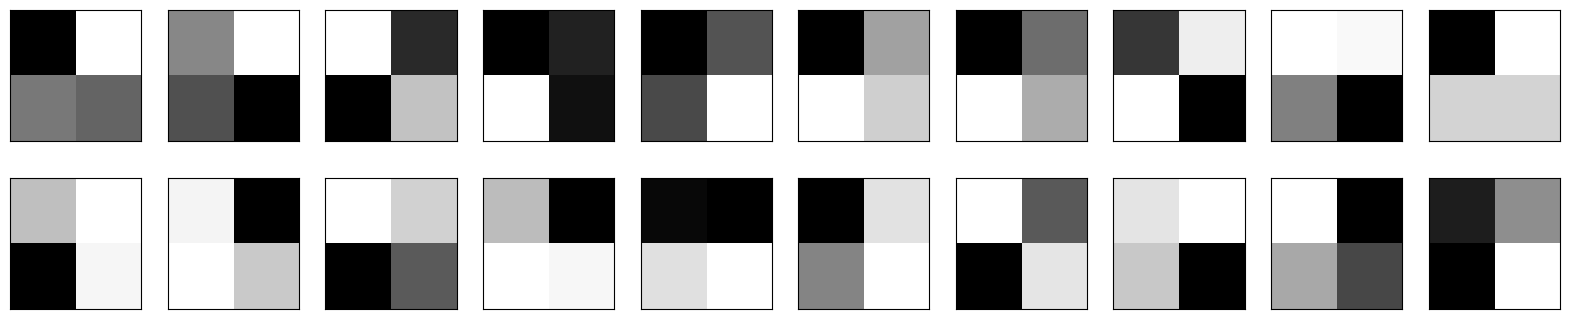

In [6]:
# Sample 20 noisy images

noise = [np.random.random((2,2)).round(2) for i in range(20)]

_ = fn_plot_samples(noise, 2,10)

In [7]:
nn_input_dim = 4

# Discriminator class
class Discriminator():
    '''
        We can create labels and then one common loss function or we can calculate errors for
        faces and noise separately.
        In this implementation errors are calculates separately.

    '''
    def __init__(self):
        '''
            Initialize weights as per the dimensions of the incoming images
        '''
        self.weights = np.random.rand(nn_input_dim) / np.sqrt(nn_input_dim)
        self.bias = 0.0 # bias can be zero


    # Forward Pass
    def forward(self, x):
        '''
        Args:
            x : pixel value of the images or noise
        Returns:
            Activations from the discriminator using sigmoid
        '''
        return fn_sigmoid(np.dot(x, self.weights) + self.bias)


    # Forward calculation error
    def image_error(self, image):
        '''
        Args:
            image: pixel values of the image
        Return
            error:
        '''
        prediction = self.forward(image)
        # We want the prediction to be 1, so the error is -log(prediction)
        return -np.log(prediction)


    # Derivative for image
    def derivatives_from_image(self, image):
        '''
        Args:
            image: pixel values of the image
        Return
            dW, db: Gradient of weights and bias
        '''
        y_pred = self.forward(image)
        dW = image * (y_pred -1) # (a - y)
        db = y_pred-1
        return dW, db


    # Gradient updates   
    def update_from_image(self, x):
        '''
        Args:
            x: image or noise data
        Return
            none
        '''
        dW, db = self.derivatives_from_image(x)
        self.weights -= ALPHA * dW
        self.bias -= ALPHA * db


    #Error from the noise
    def noise_error(self, noise):
        '''
        Args:
            noise: pixel values of the noise
        Return
            error:error in the noise
        '''
        y_pred = self.forward(noise)
        # We want the prediction to be 0, so the error is -log(1-prediction)
        return -np.log(1-y_pred)


    # Derivatives from the noise
    def derivatives_from_noise(self, noise):
        '''
        Args:
            noise: pixel values of the noise
        Return
            dW, db: Gradient of weights and bias
        '''
        y_pred = self.forward(noise)
        dW = noise * y_pred
        db = y_pred
        return dW, db

    # Gradient update
    def update_from_noise(self, noise):
        '''
        Args:
            noise: pixel values of the noise
        Return
            none
        '''
        dW, db = self.derivatives_from_noise(noise)
        self.weights -= ALPHA * dW
        self.bias -= ALPHA * db

In [9]:
# Generator class
class Generator():

    def __init__(self):
        '''
            Initialize weights as per the dimensions of the incoming images
        '''
        self.weights = np.random.rand(nn_input_dim) / np.sqrt(nn_input_dim)
        self.biases = np.zeros(nn_input_dim) # as earlier bias can be zero
    # Forward pass
    def forward(self, z):
        '''
        Args:
            z : a random number to generate a fake face
        Returns:
            G : sigmoid ( z * W + b )
        '''
        return fn_sigmoid(z * self.weights + self.biases) # activations from generated image


    # Error Calculations
    def error(self, z, discriminator):
        '''
        Args:
            z : a random number to generate a fake face
            discriminator : Discriminator object
        Returns:
            G : sigmoid(Z.W +b)
        '''
        # generate X using this generator
        x = self.forward(z)

        # Pass through the discriminator to get y
        y = discriminator.forward(x)

        # Generator wants discriminator to predict it as image (y = 1)
        return -np.log(y)


    # Calculate the derivatives
    def derivatives(self, z, discriminator):

        '''
        Args:
            z : a random number to generate a fake face
            discriminator : Discriminator object
        Returns:
            dW, db : derivatives of weights and biases
        '''

        # Get Discriminator weights and biases
        discriminator_weights = discriminator.weights

        discriminator_bias = discriminator.bias

        # forward pass of z
        x = self.forward(z) # activations from Generator
        y = discriminator.forward(x) # activations from Generator submitted to Discriminator
        factor = - ( 1 - y ) * discriminator_weights * x *( 1 - x ) # -[ 1 - D(G(z))].W.Gi.(1-Gi)
        dW = factor * z # multiply factor by z
        db = factor

        return dW, db


    # Update generator weights
    def update(self, z, discriminator):

        '''
        Args:
            z : a random number to generate a fake face
            discriminator : Discriminator object
        Returns:
            updates the weights and biases
        '''

        # error_before = self.error(z, discriminator) # switch on for checking only

        dW, db = self.derivatives(z, discriminator)
        self.weights -= ALPHA * dW
        self.biases -= ALPHA * dW
        # error_after = self.error(z, discriminator) # switch on for checking only

In [11]:
# Hyperparameters
learning_rate = ALPHA
epochs = EPOCHS

# Instantiate the GAN
D = Discriminator()
G = Generator()

# Always a good idea to plot the errors
errors_discriminator = []
errors_generator = []

for epoch in range(EPOCHS):

    for face in faces:

        # Update the discriminator weights from the real face
        D.update_from_image(face)

        # Pick a random number to generate a fake face
        z = np.random.rand()

        # Calculate the discriminator error
        errors_discriminator.append(sum(D.image_error(face) + D.noise_error(z)))

        # Calculate the generator error
        errors_generator.append(G.error(z, D))

        # Build a fake face   , building noise
        noise = G.forward(z)

        # Update the discriminator weights from the fake face
        D.update_from_noise(noise)

        # Update the generator weights from the fake face
        G.update(z, D)

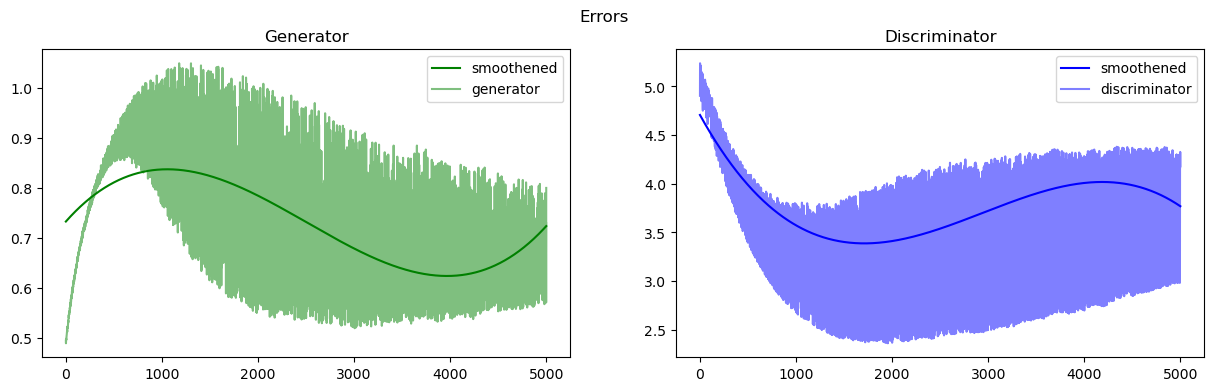

In [12]:
from scipy.interpolate import UnivariateSpline

# Plot generator errors
xnew = np.linspace(0, len(errors_generator)-1, 1000)

spl = UnivariateSpline(range(len(errors_generator)), errors_generator)

#spl.set_smoothing_factor(1)

fig, axes = plt.subplots(1,2)

axes[0].plot(xnew, spl(xnew), '-', c='g', label = 'smoothened')

axes[0].plot(errors_generator, alpha = 0.5, c='g', label = 'generator')

axes[0].set_title("Generator")

axes[0].legend()


# Plot discrimenator errors
xnew = np.linspace(0, len(errors_discriminator)-1, 1000)

spl = UnivariateSpline(range(len(errors_discriminator)), errors_discriminator)

#spl.set_smoothing_factor(500)

axes[1].plot(xnew, spl(xnew), '-', c='b', label = 'smoothened')

axes[1].plot(errors_discriminator, alpha = 0.5, c='b', label = 'discriminator')

axes[1].legend()

axes[1].set_title("Discriminator")

plt.suptitle('Errors')

plt.show()

### Note:
As expected, error trends are opposite!

In [13]:
generated_images = []
for i in range(100):

    z = np.random.random() # generate a random number

    generated_image = G.forward(z) # call forward method of Generator class

    generated_images.append(generated_image)


#for i in generated_images:
#    print(i.round(2))

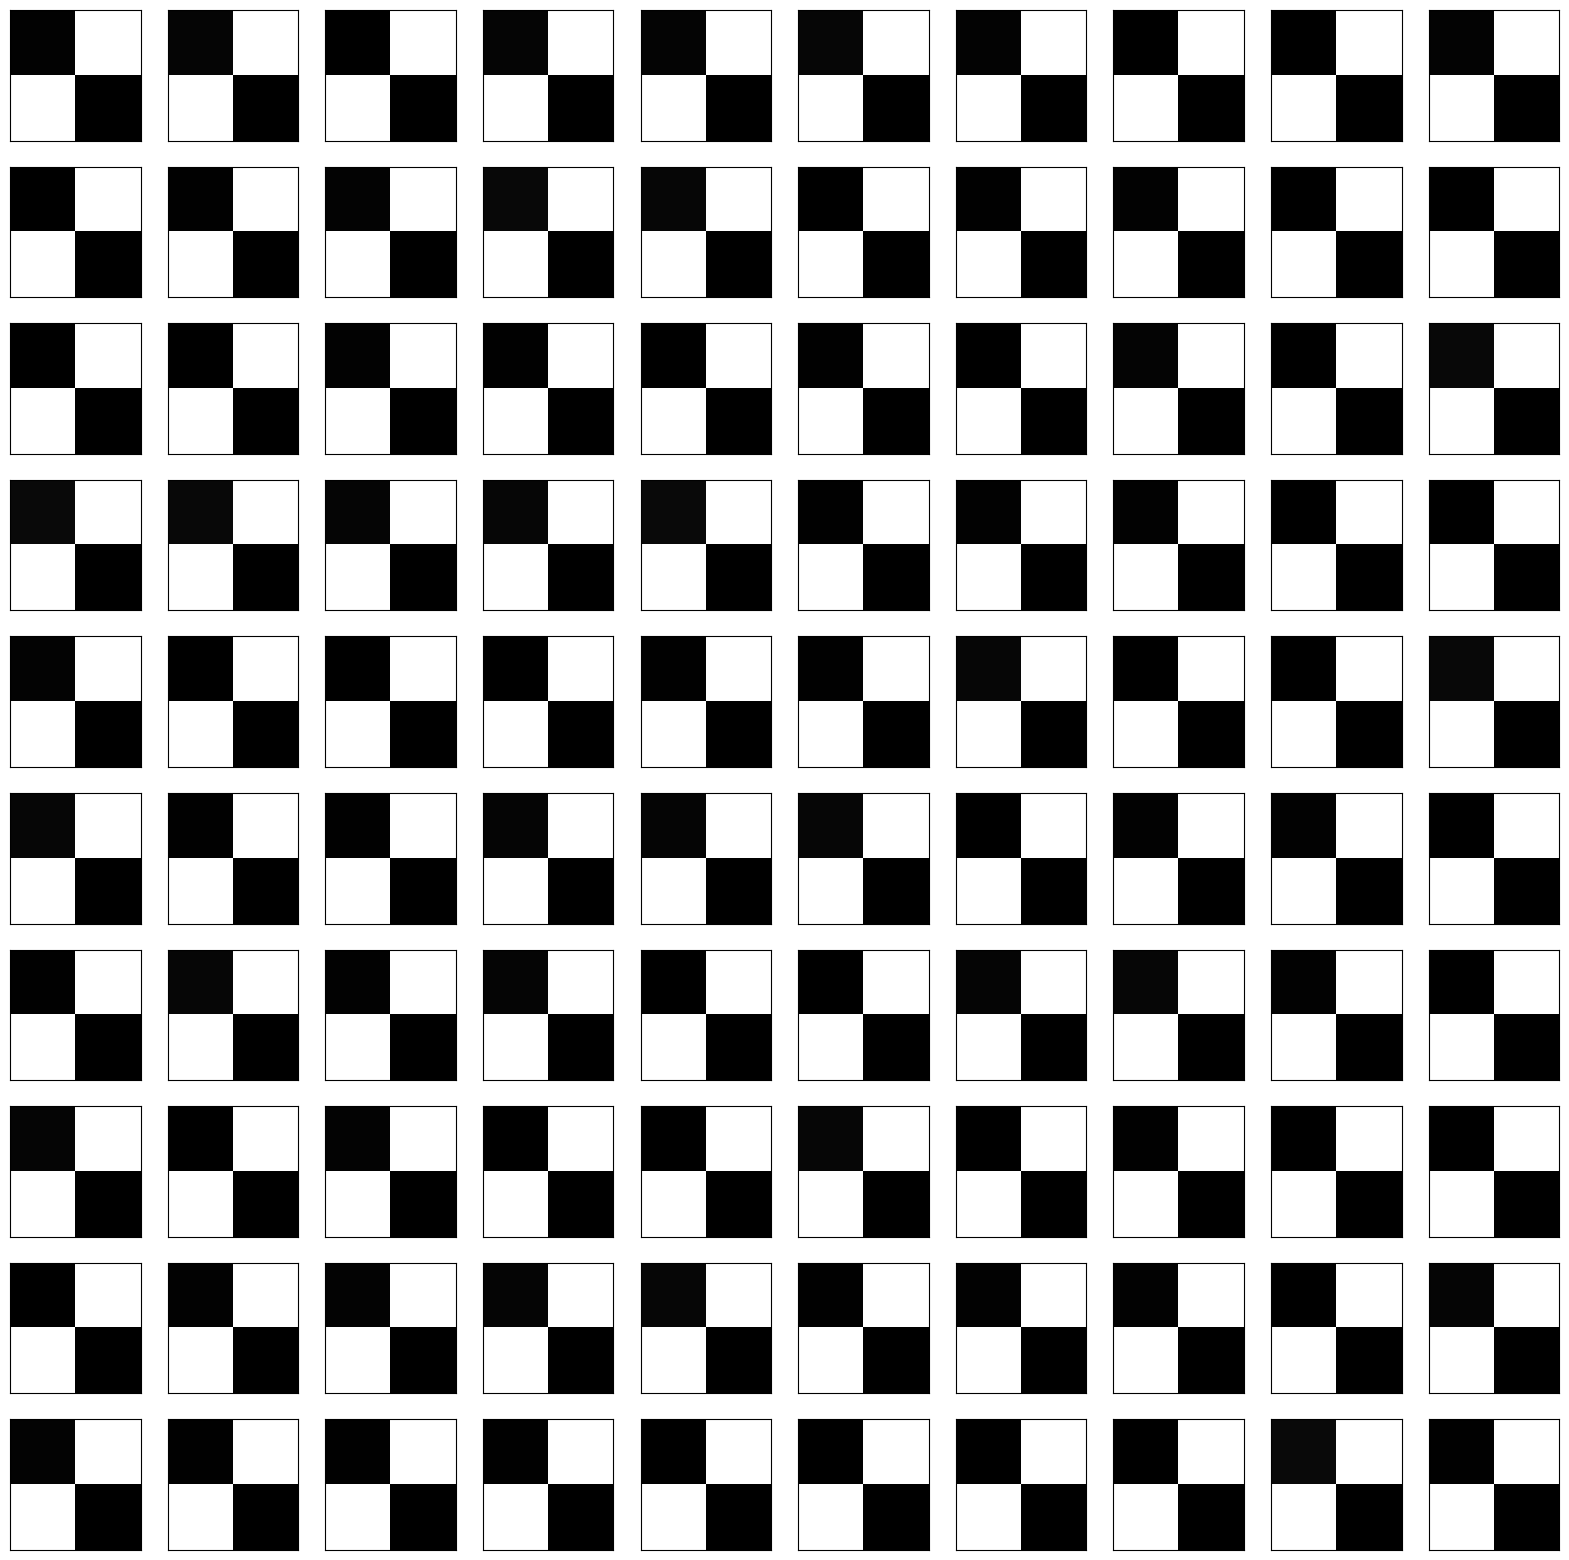

In [14]:
_ = fn_plot_samples(generated_images, 10, 10)

In [15]:
print("Generator weights", G.weights)
print("Generator biases", G.biases)

Generator weights [ 1.78749852 -1.84727262 -1.88097928  1.61579862]
Generator biases [ 1.44836208 -1.94724576 -1.93215626  1.61240947]


In [16]:
print("Discriminator weights", D.weights)
print("Discriminator bias", D.bias)

Discriminator weights [ 0.88151557 -1.21267734 -1.17355401  0.84241633]
Discriminator bias -1.3398771512343568
